In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose

import IPython
import IPython.display

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

mpl.rcParams['figure.figsize'] = (16, 6)
mpl.rcParams['axes.grid'] = False

sns.set_theme(style='whitegrid')
sns.set(rc={'figure.figsize': (16., 6.)})

In [2]:
df = pd.read_excel('./countries_gas.xlsx', index_col=0)
raw_data = df
df

,USA,"Japan,South Korea",Eupora
Date,,,
1984-01-01,59191.20,3158.67,33524.59
1984-02-01,49898.24,2902.67,32041.52
1984-03-01,53440.16,3397.67,30465.52
1984-04-01,41004.24,3065.67,23029.52
1984-05-01,35196.24,2932.67,19727.56
...,...,...,...
2020-08-01,65728.00,12880.00,28154.50
2020-09-01,57408.00,11753.00,32761.60
2020-10-01,61568.00,12075.00,37880.60


In [3]:
# Страна, для которой выполняется прогноз
# Если при прогнозе других стран результат получется не очень, убрать год из фичей 
COUNTRY = 'USA'
COUNTRY_NAME = 'США'

# Признак, упрощать ли модели (используется для модели СВА, так как она склонна к переобучению)
REDUCE_MODELS = False

trend = None
if COUNTRY == 'Japan,South Korea':    
    seasonal_decomposition = seasonal_decompose(df[COUNTRY], model='additive')
    trend = seasonal_decomposition.trend[seasonal_decomposition.trend>0]
#     print(result.trend)
    seasonal_decomposition.plot()

    df[COUNTRY] = df[COUNTRY] - result.trend # np.log(df[COUNTRY].values)


In [4]:
df = df.dropna()

In [5]:
def plot_gas_consumption(country=COUNTRY, country_name=COUNTRY_NAME):
    ax = sns.lineplot(data=df[country], palette='tab10', linewidth=2.5)
    ax.set(xlabel='Год', ylabel='Потребление газа, млн м3', title=f'Потребление газа в {country_name}')
    plt.show()

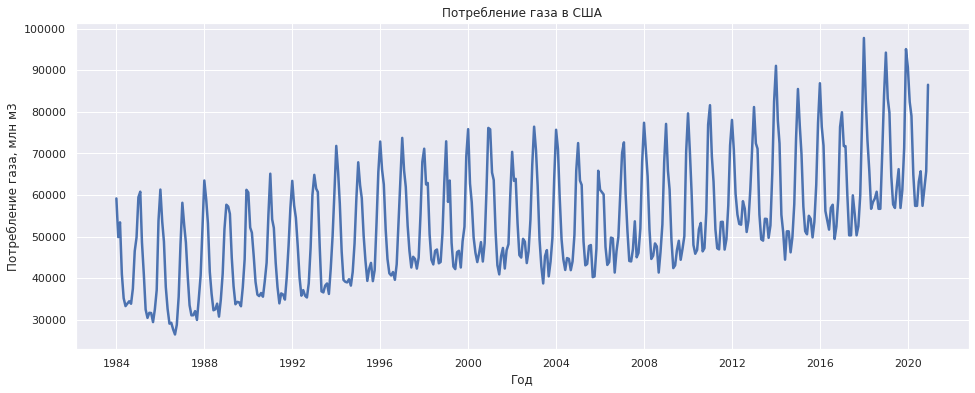

In [6]:
plot_gas_consumption()

# Расширение признаков

In [7]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)
month = df.index.month

month_sin = np.sin(2 * np.pi * month/12.0)
month_cos = np.cos(2 * np.pi * month/12.0)

df['month_sin'] = month_sin
df['month_cos'] = month_cos
df['year'] = df.index.year

# Порционирование данных

In [8]:
from sklearn.preprocessing import StandardScaler

def get_data(country=COUNTRY, test_size=72):     
    data = pd.DataFrame({
        'target': df[country],
        'month_sin': df.month_sin,
        'month_cos': df.month_cos,
        'year': df.year,
    })
    data = data.set_index(df.index)
    
    scaler = StandardScaler()
    scaler.fit(data)
    transformed = scaler.transform(data)
    
    target_scaler = StandardScaler()
    target_scaler.fit(df[COUNTRY].values.reshape(-1, 1))
    
    column_indices = {name: i for i, name in enumerate(data.columns)}
    
    for column in data.columns:
        data[column] = transformed[:, column_indices[column]]
    
    num_features = data.shape[1]

    # 5 лет в тестовую выборку
    split_index = data.shape[0] - test_size
    train_data = data[:split_index]
    test_data = data[split_index:]
    return data, train_data, test_data, column_indices, num_features, split_index, target_scaler

In [9]:
full_data, train_data, test_data, column_indices, num_features, split_index, scaler = get_data(COUNTRY)

In [10]:
full_data

,target,month_sin,month_cos,year
Date,,,,
1984-01-01,0.447487,7.071068e-01,1.224745e+00,-1.685854
1984-02-01,-0.242941,1.224745e+00,7.071068e-01,-1.685854
1984-03-01,0.020209,1.414214e+00,1.502480e-16,-1.685854
1984-04-01,-0.903727,1.224745e+00,-7.071068e-01,-1.685854
1984-05-01,-1.335237,7.071068e-01,-1.224745e+00,-1.685854
...,...,...,...,...
2020-08-01,0.933144,-1.224745e+00,-7.071068e-01,1.685854
2020-09-01,0.315003,-1.414214e+00,-1.961344e-16,1.685854
2020-10-01,0.624073,-1.224745e+00,7.071068e-01,1.685854


In [11]:
print(f'Train data size: {len(train_data)} (from {train_data.index[0].year}-{train_data.index[0].month} to {train_data.index[-1].year}-{train_data.index[-1].month})')
print(f'Test data size: {len(test_data)} (from {test_data.index[0].year}-{test_data.index[0].month} to {test_data.index[-1].year}-{test_data.index[-1].month})')

Train data size: 372 (from 1984-1 to 2014-12)
Test data size: 72 (from 2015-1 to 2020-12)


In [12]:
class WindowGenerator():
    def __init__(self, 
                 input_width, 
                 label_width, 
                 shift,
                 train_df, test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels  
    
    def plot(self, model=None, plot_col='target', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'Прогноз [норм-е]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Исходные данные', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Прогнозируемые данные', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Прогнозы по модели',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Время')    
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds     
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
        # And cache it for next time
        self._example = result
        return result    

# Multi-step model

In [13]:
def plot_history(history, metrics=['loss', 'val_loss'], offset=0):
    for metric in metrics:
        plt.plot(history.history[metric][offset:], label=metric)
    plt.legend()
    plt.show()

In [14]:
MAX_EPOCHS = 1500

def compile_and_fit(model, window, patience=100):
    
    early_stopping = None
    if patience > 0:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min',
                                                        restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])  # , tf.metrics.MeanAbsolutePercentageError()

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.test,
                      callbacks=[early_stopping] if early_stopping else [])
    return history

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): ['target']

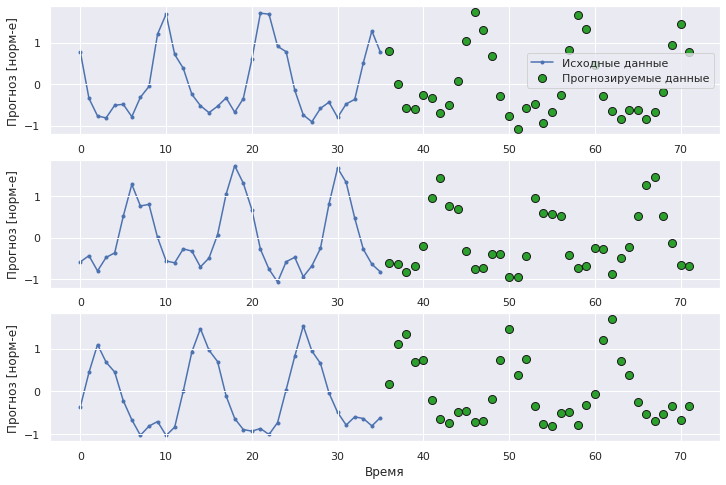

In [15]:
OUT_STEPS = 36
window_size = 36

multi_window = WindowGenerator(input_width=window_size,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_data,
                               test_df=test_data,
                               label_columns=['target'])

multi_window.plot()
multi_window

In [16]:
multi_performance = {}

1/1 [==============================] - 0s 51ms/step - loss: 0.5042 - mean_absolute_error: 0.5730


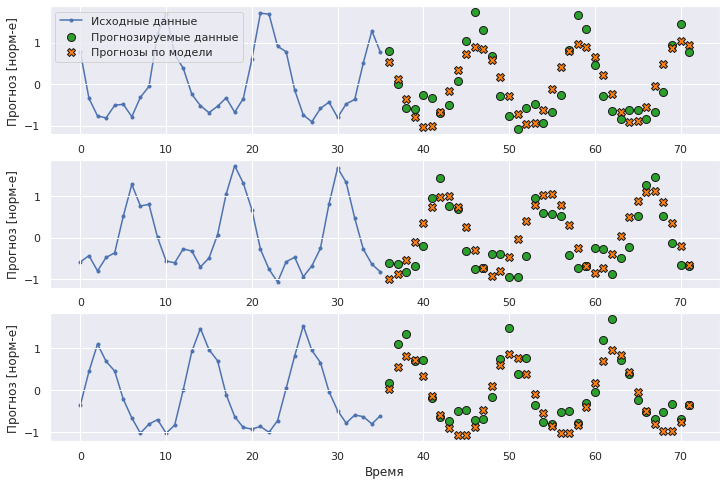

In [17]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
# multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(multi_linear_model)

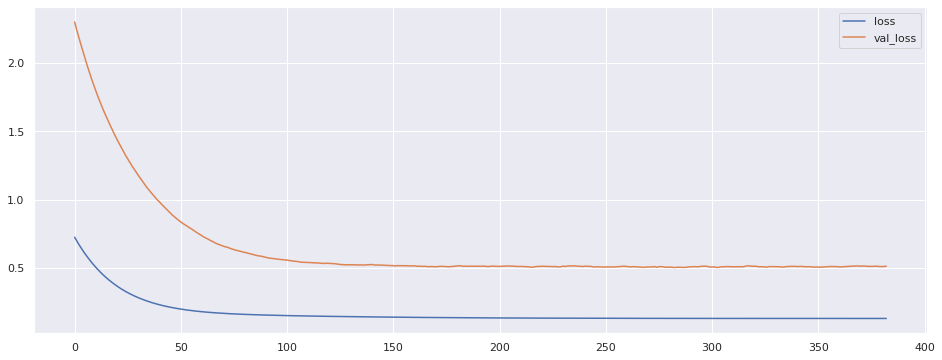

In [18]:
plot_history(history)

1/1 [==============================] - 0s 52ms/step - loss: 0.1754 - mean_absolute_error: 0.3201


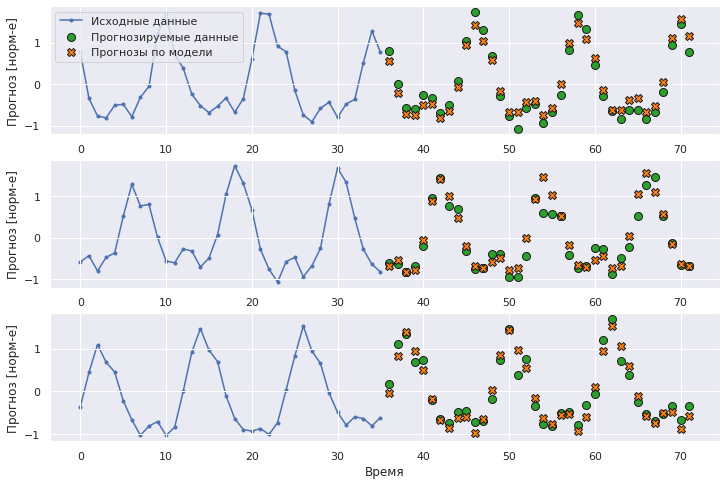

In [19]:
if REDUCE_MODELS:
    multi_dense_model = tf.keras.Sequential([
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(8, activation='relu'),
#         tf.keras.layers.Dense(8, activation='relu'),
#         tf.keras.layers.Dense(8, activation='relu'),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
else:
    multi_dense_model = tf.keras.Sequential([
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(16, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
# multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(multi_dense_model)

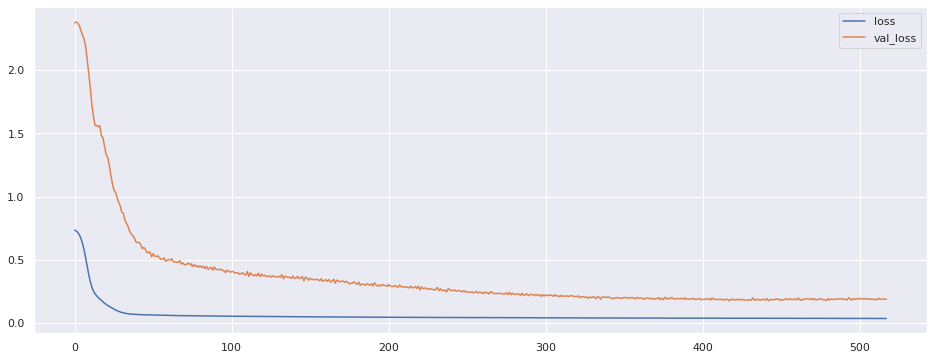

In [20]:
plot_history(history)

1/1 [==============================] - 0s 43ms/step - loss: 0.1093 - mean_absolute_error: 0.2541


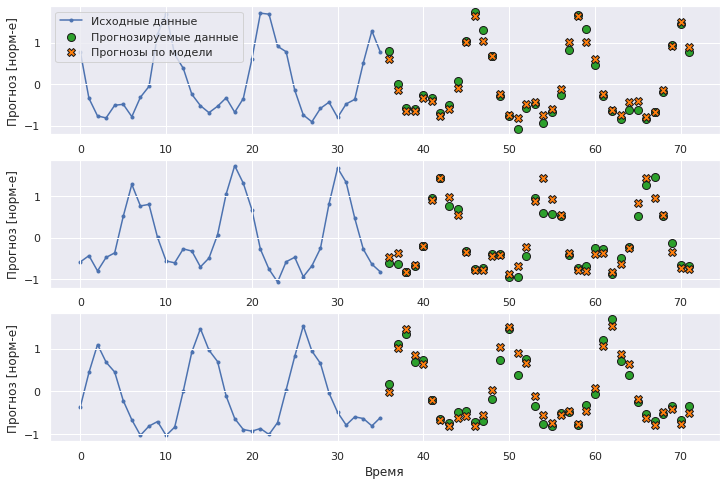

In [21]:
if REDUCE_MODELS:
    CONV_WIDTH = 3
    multi_conv_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(4, activation='relu', kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1,  out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
else:
    CONV_WIDTH = 3
    multi_conv_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1,  out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])


history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(multi_conv_model)


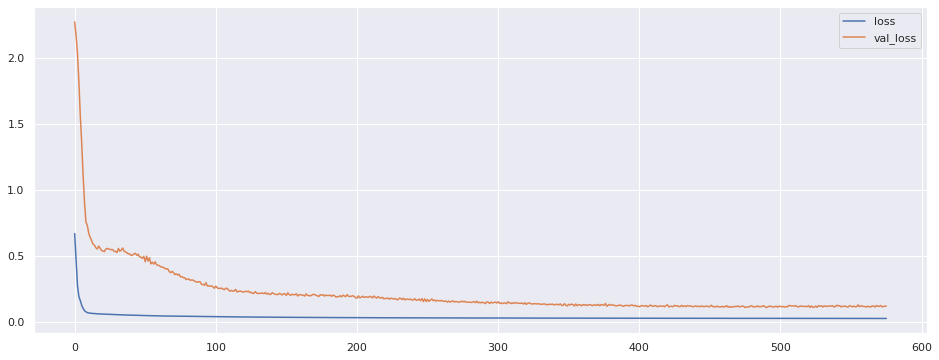

In [22]:
plot_history(history)

1/1 [==============================] - 0s 48ms/step - loss: 0.4002 - mean_absolute_error: 0.5170


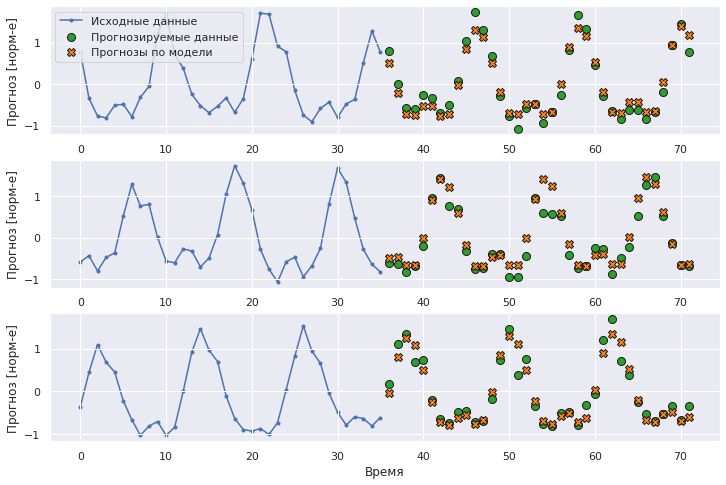

In [23]:
if REDUCE_MODELS:
    multi_lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units]
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(4, return_sequences=False),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
else:
    multi_lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units]
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(16, return_sequences=True),
        tf.keras.layers.LSTM(16, return_sequences=False),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    


history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(multi_lstm_model)

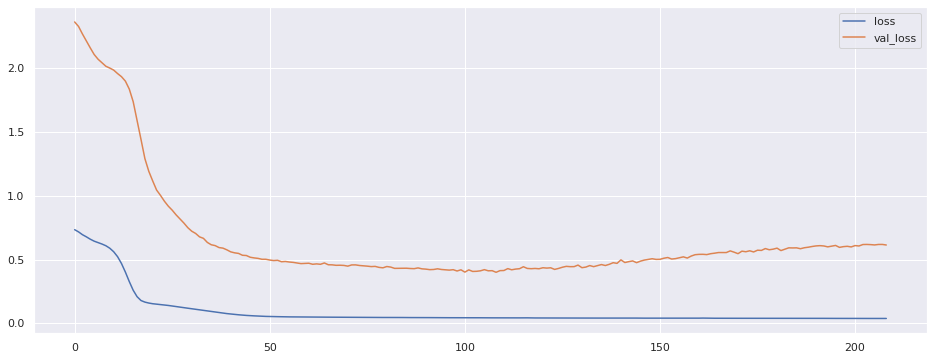

In [24]:
plot_history(history)

1/1 [==============================] - 0s 65ms/step - loss: 0.2897 - mean_absolute_error: 0.4698


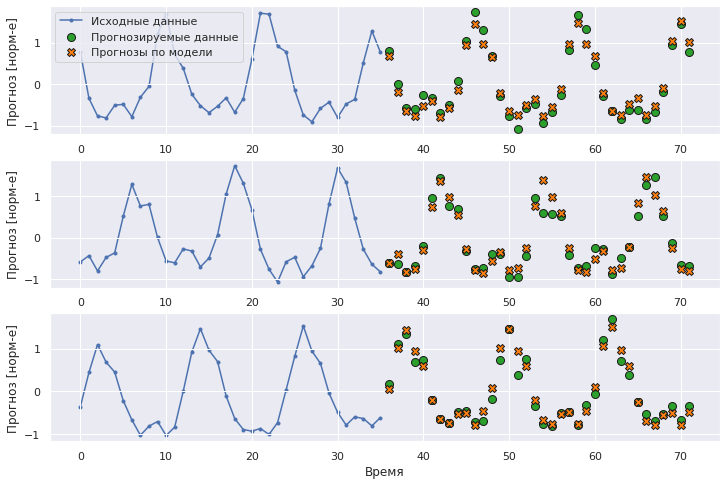

In [25]:
if REDUCE_MODELS:
    multi_gru_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units]
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.GRU(16, return_sequences=False),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
else:
    multi_gru_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units]
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.GRU(16, return_sequences=True),
        tf.keras.layers.GRU(16, return_sequences=False),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])


history = compile_and_fit(multi_gru_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(multi_gru_model)

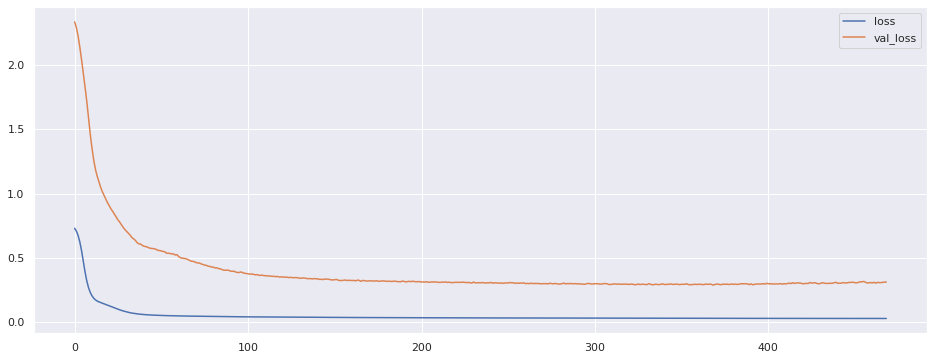

In [26]:
plot_history(history)

In [27]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, rnn_type='lstm'):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        if rnn_type == 'lstm':
            self.cell = tf.keras.layers.LSTMCell(units)
        elif rnn_type == 'gru':
            self.cell = tf.keras.layers.GRUCell(units)
            
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.rnn = tf.keras.layers.RNN(self.cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions    

In [28]:
if REDUCE_MODELS:
    feedback_model = FeedBack(units=8, out_steps=OUT_STEPS)
else:
    feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [29]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 4])

In [30]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 36, 4)


1/1 [==============================] - 0s 55ms/step - loss: 0.4391 - mean_absolute_error: 0.5546


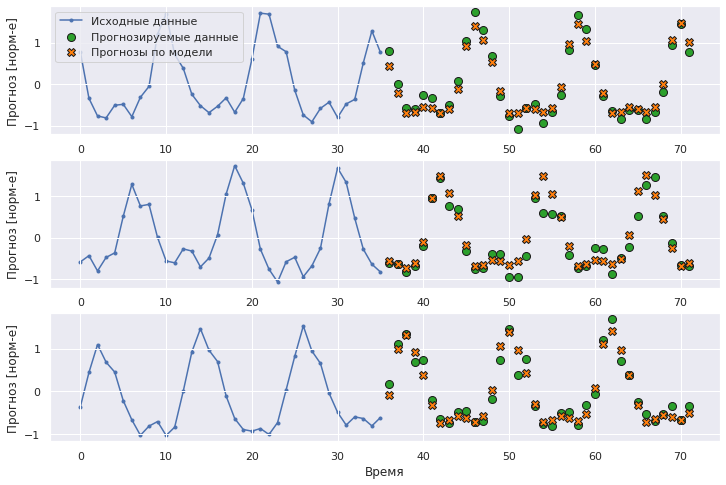

In [31]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(feedback_model)

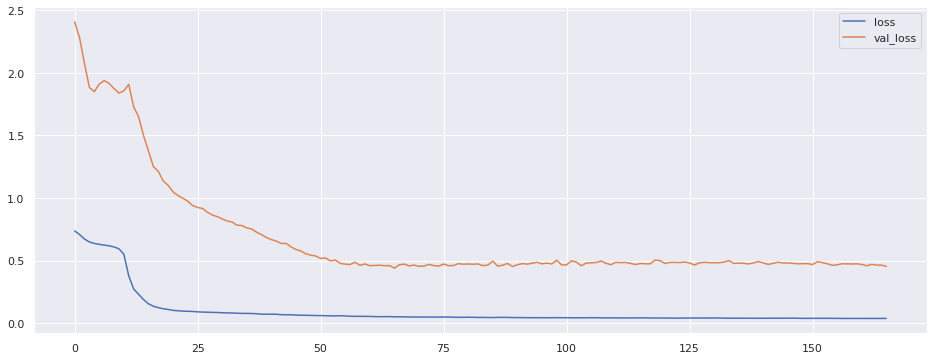

In [32]:
plot_history(history)

1/1 [==============================] - 0s 61ms/step - loss: 0.4047 - mean_absolute_error: 0.5656


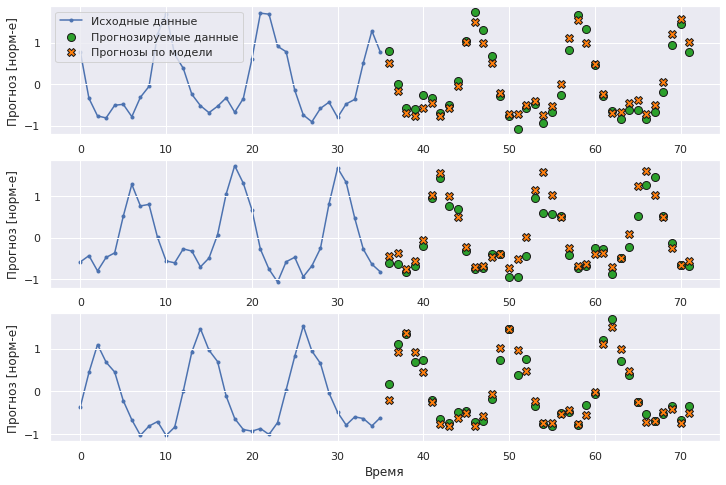

In [33]:
if REDUCE_MODELS:
    feedback_model_gru = FeedBack(units=8, out_steps=OUT_STEPS, rnn_type='gru')
else:
    feedback_model_gru = FeedBack(units=32, out_steps=OUT_STEPS, rnn_type='gru')

history = compile_and_fit(feedback_model_gru, multi_window)

IPython.display.clear_output()

# multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR GRU'] = feedback_model_gru.evaluate(multi_window.test, verbose=1)
multi_window.plot(feedback_model_gru)

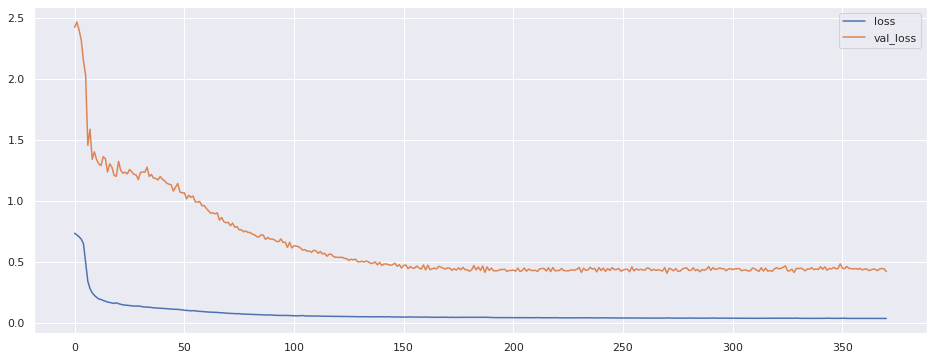

In [34]:
plot_history(history)

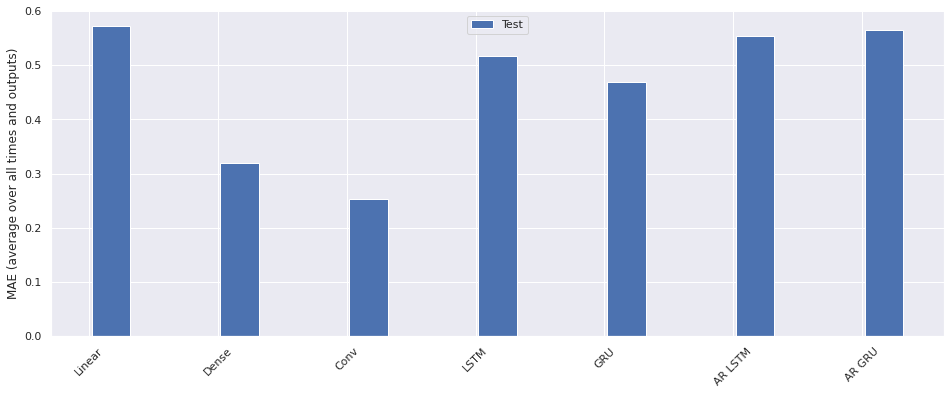

In [35]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

# plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [36]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Linear  : 0.5730
Dense   : 0.3201
Conv    : 0.2541
LSTM    : 0.5170
GRU     : 0.4698
AR LSTM : 0.5546
AR GRU  : 0.5656


# Best model

In [37]:
def forecast(model, plot=True, trend=None):
    forecast = []

    for time in range(len(full_data) - window_size):
        res = model.predict(full_data[time:time + window_size].values[np.newaxis])
        forecast.append(res)

    forecast = forecast[split_index-window_size:]
    results = np.array(forecast)[:, 0, 0]
    results = results[:, 0]
    
#     if COUNTRY == 'Japan,South Korea':  
#         results += trend[-len(results):].values
    
    if plot:
        add_history_values = [0] * len(train_data['target'])
        add_future_values =  [0] * len(test_data['target'])
        if trend is not None:
            add_history_values = trend[:-len(results)]
            add_future_values = trend[len(trend)-len(results):]

        plt.plot(train_data.index.values, add_history_values + scaler.inverse_transform(train_data['target']), 'g', label='Фактические данные')
        plt.plot(test_data.index.values, add_future_values + scaler.inverse_transform(test_data['target']), marker='.', label='Прогнозируемые реальные данные')
        plt.plot(test_data.index.values, add_future_values + scaler.inverse_transform(results), 'r', label='Прогноз по модели')
        plt.ylabel('Объем потребления газа (норм-е данные)')
        plt.xlabel('Время')
        plt.legend()
        plt.show(); 

        # Scale predictions
        plt.plot(test_data.index.values, test_data['target'], marker='.', label="true")
        plt.plot(test_data.index.values, results, 'r', label='Прогноз по модели')
        plt.ylabel('Значения')
        plt.xlabel('Время')
        plt.legend()
        plt.show();
            
    return results

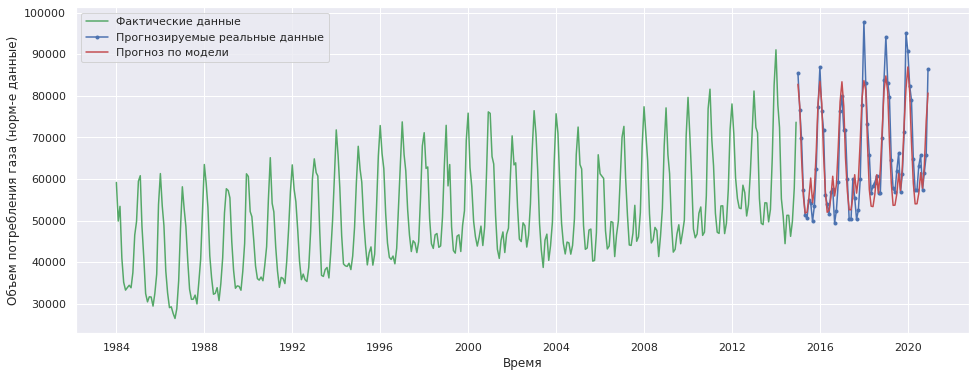

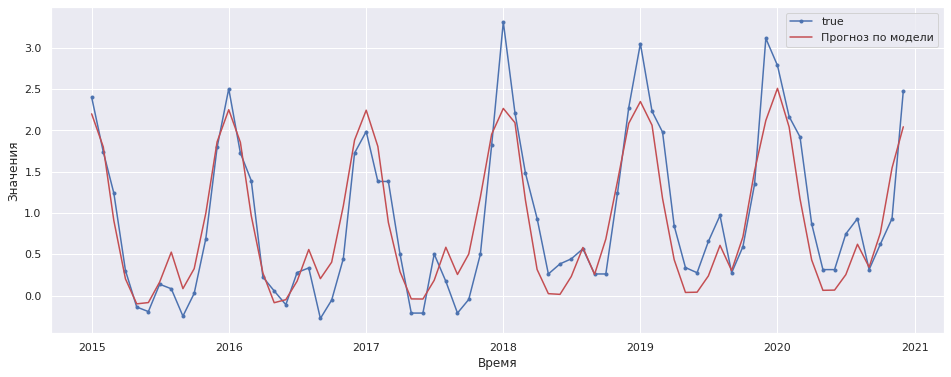

In [38]:
results = forecast(multi_dense_model, trend=trend) # multi_dense_model multi_conv_model multi_gru_model feedback_model